In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import statsmodels.api as sm

import scipy.stats as stats
import scipy.cluster.vq as cluster

import glob

In [2]:
"""Import and create frame indices from RSV Catalog"""

filename = 'RSV_Digi_Catalog.csv'
idx_data = pd.read_csv(filename)
idx_data.columns = idx_data.columns.str.strip().str.replace(" ","_").str.lower()
idx_data = idx_data.astype('float64', errors='ignore')

keypts_col = ['breast_impact','base_of_bill_start', 'base_of_bill_end', 'tip_of_bill_start', 'tip_of_bill_end', 'shoulder_start', 'shoulder_end', 'base_of_tail_start', 'base_of_tail_end']
keypts_df = idx_data[keypts_col].isnull().any(axis=1)
bad_digis_idx = idx_data[keypts_df == True].index
idx_data.drop(bad_digis_idx, inplace=True)

ntrials, columns = idx_data.shape
new_index = np.linspace(0, ntrials, ntrials, False)
new_index = np.array(new_index + 1)
new_idx = new_index.astype(int)

idx_data.set_index(new_idx, inplace = True)

stt_idx = []
end_idx = []
for i in idx_data.index:
    stt = idx_data.loc[i, ['shoulder_start','base_of_tail_start','base_of_bill_start', 'tip_of_bill_start']].max()
    stt_idx.append(stt)
    end = idx_data.loc[i, ['base_of_bill_end', 'tip_of_bill_end', 'shoulder_end', 'breast_impact']].min()
    end_idx.append(end)

idx_data = idx_data.join(pd.Series(stt_idx, name='start_index', index=new_idx)).join(pd.Series(end_idx, name='end_index', index=new_idx))

idx_data['initial_impact'] = np.where(idx_data['feet_impact'] > idx_data['end_index'], 'no', 'yes')
idx_data['complete_transition'] = np.where(idx_data['breast_impact'] > idx_data['end_index'], 'no', 'yes')
idx_data['base_of_tail_during_approach'] = idx_data.where(idx_data['base_of_tail_end'] < idx_data['feet_impact']).any(axis=1)

no_impact_idx = idx_data[idx_data['initial_impact'] == 'no'].index
idx_data.drop(no_impact_idx, inplace=True)
no_BoT_idx = idx_data[idx_data['base_of_tail_during_approach'] == True].index
idx_data.drop(no_BoT_idx, inplace=True)

ntrials, columns = idx_data.shape
new_index = np.linspace(0, ntrials, ntrials, False)
new_index = np.array(new_index + 1)
new_idx = new_index.astype(int)

idx_data.set_index(new_idx, inplace = True)
idx_data['date'] = idx_data['date'].astype(str).str.strip('.0')

ntrials = idx_data['date'].size



In [3]:
idx_data

,date,video,feet_extended,feet_impact,breast_impact,tail_flip,base_of_bill_start,base_of_bill_end,tip_of_bill_start,tip_of_bill_end,...,ankle_end,heel_start,heel_end,toe_start,toe_end,start_index,end_index,initial_impact,complete_transition,base_of_tail_during_approach
1,20181025,B01a,33.0,53.0,60.0,NaN,34.0,156.0,34.0,156.0,...,52.0,34.0,51.0,34.0,51.0,34.0,60.0,yes,yes,False
2,20181025,B01b,NaN,46.0,57.0,NaN,32.0,98.0,32.0,98.0,...,NaN,NaN,NaN,NaN,NaN,32.0,50.0,yes,no,False
3,20181025,B01c,NaN,47.0,64.0,NaN,22.0,162.0,22.0,162.0,...,47.0,22.0,46.0,22.0,46.0,22.0,60.0,yes,no,False
4,20181025,B02,36.0,53.0,66.0,NaN,27.0,64.0,27.0,64.0,...,57.0,27.0,52.0,27.0,52.0,27.0,64.0,yes,no,False
5,20181025,B04,NaN,66.0,88.0,142.0,51.0,81.0,51.0,81.0,...,68.0,51.0,66.0,51.0,65.0,51.0,81.0,yes,no,False
6,20181025,C01a,162.0,184.0,194.0,NaN,11.0,214.0,31.0,214.0,...,NaN,NaN,NaN,NaN,NaN,31.0,194.0,yes,yes,False
7,20181101,A01,33.0,38.0,58.0,104.0,2.0,104.0,2.0,104.0,...,41.0,2.0,38.0,2.0,39.0,2.0,53.0,yes,no,False
8,20181101,A02a,21.0,30.0,55.0,NaN,10.0,55.0,10.0,53.0,...,31.0,10.0,29.0,10.0,28.0,10.0,51.0,yes,no,False
9,20181108,A02a,NaN,28.0,34.0,NaN,15.0,37.0,15.0,37.0,...,27.0,15.0,27.0,NaN,NaN,15.0,34.0,yes,yes,False
10,20181108,A02c,NaN,63.0,69.0,NaN,17.0,64.0,17.0,64.0,...,NaN,NaN,NaN,NaN,NaN,17.0,64.0,yes,no,False


In [4]:
def csv_import(filename, header = True):
    import csv
    file = open(filename)
    readfile = csv.reader(file)
    listfile = list(readfile)
    if header == True:
        headers = listfile[0]
        data = listfile[1:]
    else:
        data = listfile
    return headers, data

In [5]:
def interp_cubicspline(data):
    
    pos_axes = ['x', 'y', 'z']
    
    df = pd.DataFrame(data, columns=pos_axes, dtype=float)
    iseries = df['x'].multiply(1000).interpolate(method='cubic', axis=0, limit=None, limit_direction='both', limit_area='inside')
    df['x'] = iseries
    iseries = df['y'].multiply(1000).interpolate(method='cubic', axis=0, limit=None, limit_direction='both', limit_area='inside')
    df['y'] = iseries
    iseries = df['z'].multiply(1000).interpolate(method='cubic', axis=0, limit=None, limit_direction='both', limit_area='inside')
    df['z'] = iseries
    
    interp_data = df.values
    return interp_data

In [6]:
def but(pr, fs, fc, order=2, padlen=None):
    """Smooth with two passes of a Butterworth filter and calculate
    velocity and acceleration with finite differences.

    Parameters:
    pr = (ntime x nmark x 3) raw data array
    fs = sampling rate
    fc = Butterworth filter cutoff frequency (pick this from a
        residual analysis)
    order = filter order (default is 2)
    padlen = padding to use in filtfilt (default is None, so use
        ntime - 1 length of padding)

    Returns:
    out = dict that holds filtered position and calculated velocity
        and accleration; also return Wn, the fraction of the Nyquist
        used to construct the filter coefficients
    """

    ntime, nmark, ncoord = pr.shape

    fny = fs / 2  # Nyquist frequency
    Wn = fc / fny  # non-dimensional fraction of the Nyquist
    dt = 1 / fs  # measurement interval

    # get the filter coefficients
    butb, buta = butter(order, Wn)

    # padlen for filtfilt
    if padlen is None:
        padlen = ntime - 1

    # iterate through each marker and coordinate, smooth, and calculate
    # velocities and accelerations
    pf, vf, af = pr.copy(), pr.copy(), pr.copy()
    for j in np.arange(nmark):
        for k in np.arange(ncoord):
            d = pr[:, j, k]
            p = filtfilt(butb, buta, d, padlen=padlen)
            v, a = findiff(p, dt)
            pf[:, j, k], vf[:, j, k], af[:, j, k] = p, v, a

    out = {'p': pf, 'v': vf, 'a': af, 'Wn': Wn}
    return out

In [7]:
def but_fcs(pr, fs, fcs, order=2, padlen=None):
    """Smooth with two passes of a Butterworth filter and calculate
    velocity and acceleration with finite differences. However, use
    different cutoff frequencies for each marker and x, y, z
    time series.

    Parameters
    ----------
    pr = (ntime x nmark x ncoord) array
        raw data array
    fs = float
        sampling rate
    fcs = (nmark x ncoord) array
        Butterworth filter cutoff frequencies (pick this from the residual
        analysis)
    order = integer
        filter order (default is 2)
    padlen = integer or None
        padding to use in filtfilt (default is None, so use time - 1 length
        of padding)

    Returns
    -------
    out = dict
        Holds filtered position and calculated velocity
        and accleration; also return Wns, the fraction of the Nyquist
        used to construct the filter coefficients for each marker in
        the x, y, and z positions.
    """

    ntime, nmark, ncoord = pr.shape
    dt = 1 / fs  # measurement interval

    fny = fs / 2  # Nyquist frequency
    Wns = fcs / fny  # non-dimensional fraction of the Nyquist

    # padlen for filtfilt
    if padlen is None:
        padlen = ntime - 1

    # iterate through each marker and coordinate, smooth, and calculate
    # velocities and accelerations
    pf, vf, af = pr.copy(), pr.copy(), pr.copy()
    for j in np.arange(nmark):
        for k in np.arange(ncoord):
            # construct the filter
            butb, buta = butter(order, Wns[j, k])

            # select data and perform filtering
            d = pr[:, j, k]
            p = filtfilt(butb, buta, d, padlen=padlen)
            v, a = findiff(p, dt)
            pf[:, j, k], vf[:, j, k], af[:, j, k] = p, v, a

    out = {'p': pf, 'v': vf, 'a': af, 'Wns': Wns}
    return out

In [8]:
def residual_butter(pr, fs, order=2, df=.1, fmin=1, fmax=35):
    """Calculate RMS residuals to determine a proper cutoff frequency
    for a Butterworth filtering.

    Parameters:
    pr = (ntime x nmark x 3) raw data array
    fs = sampling frequency
    order = order filter to use, default is 2
    df = difference between frequencies
    fmin = min freq to try, default is 1
    fmax = max freq to try, default is 35

    Returns:
    R = residual array of (nfreq x nmark x 3) that has the RMS residual
        for a given marker is in X, Y, and Z directions.
    fcs = array of cutoff frequencies tried
    """

    ntime, nmark, ncoord = pr.shape

    # fcs = np.linspace(fmin, fmax, nfreq)
    fcs = np.arange(fmin, fmax + .01, df)
    nfreq = round(len(fcs))
    R = np.zeros((nfreq, nmark, 3))

    for i, fc in enumerate(fcs):
        out = but(pr, fs, fc, order)
        R[i] = np.sqrt(np.mean((pr - out['p'])**2, axis=0))

    return R, fcs

In [9]:
def opt_cutoff(R, fcs, rsq_cutoff=.95):
    """Find an 'optimum' cutoff frequency based on the residuals.

    Parameters:
    R = (nfreq x nmark x 3) array of residuals
    fcs = cutoff frequences used
    rsq_cutoff = coefficient of determination minimum that determines the
        frequency to perform the noise fit

    Returns:
    inter = (nmark x ncoord) array of y-intercepts in mm
    fcopt = (nmark x ncoord) array of 'optimum' cutoff frequencies
    rsq = (nmark x ncoord) array of R^2 values
    flinreg = (2 x nmark x ncoord) array of the fmin, fmax values to
        construct the linear regression to get the cutoff frequency

    Notes:
    This function fits a linear line to the tail of the residual, finds
    the intercept (a residual) and the corresponding cutoff frequency
    this residual corresponds to. This is a 'rough' find, that is, it
    finds the nearest freqeuncy in the array of provided requencies and does
    not do root finding of an interpolation function, etc.

    http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
    """
    from scipy.stats import linregress
    from scipy.optimize import newton
    from scipy.interpolate import interp1d

    nfreq, nmark, ncoord = R.shape

    inter = np.zeros((nmark, ncoord))
    fcopt = np.zeros((nmark, ncoord))
    rsq = np.zeros((nmark, ncoord))
    flinreg = np.zeros((2, nmark, ncoord))

    for j in np.arange(nmark):
        for k in np.arange(3):
            # res = R[idx, j, k]
            res = R[:, j, k]

            # iterative find the min freq to perform interpolation
            # step backwards through the array, until rsq drops to rsq_cutoff
            ixcut = np.inf  # if don't get into inf, this will throw an error
            for mm in np.arange(nfreq - 2, 0, -1):
                slope, intercept, r_value, p_value, std_err = \
                    linregress(fcs[mm:], res[mm:])
                # print r_value**2
                if r_value**2 < rsq_cutoff:
                    ixcut = mm + 1
                    break

            # once we go under rsq_cutoff, use the previous value
            slope, intercept, r_value, p_value, std_err = \
                linregress(fcs[ixcut:], res[ixcut:])

            # optimize the cutoff frequency
            def tozero(freq_guess):
                return resid_interp(freq_guess) - intercept

            # interpolation function of the residuals
            resid_interp = interp1d(fcs, res)
            fopt_guess = fcs[np.argmin(np.abs(res - intercept))]
            fopt = newton(tozero, fopt_guess)

            # store the values
            inter[j, k] = intercept
            fcopt[j, k] = fopt
            rsq[j, k] = r_value**2
            flinreg[:, j, k] = fcs[ixcut], fcs[-1]

    return inter, fcopt, rsq, flinreg

In [10]:
def findiff(p, dt):
    """Second-order accurate finite difference velocites and accelerations.

    Parameters:
    p = 1D array (size ntime) to take finite difference of
    dt = time step between measurements

    Returns:
    v = velocity
    a = acceleration

    Finite difference code from:
    See: https://en.wikipedia.org/wiki/Finite_difference_coefficient

    We are using 2nd order accurate central, forward, and backward finite
    differences.
    """

    n = len(p)
    v, a = np.zeros_like(p), np.zeros_like(p)

    # at the center
    for i in np.arange(1, n - 1):
        v[i] = .5 * p[i + 1] - .5 * p[i - 1]
        a[i] = p[i + 1] - 2 * p[i] + p[i - 1]

    # left boundary (forward difference)
    v[0] = -1.5 * p[0] + 2 * p[1] - .5 * p[2]
    a[0] = 2 * p[0] - 5 * p[1] + 4 * p[2] - p[3]

    # right boundary (backward differences)
    v[-1] = 1.5 * p[-1] - 2 * p[-2] + .5 * p[-3]
    a[-1] = 2 * p[-1] - 5 * p[-2] + 4 * p[-3] - p[-4]

    return v / dt, a / dt**2

In [11]:
def filterpositions(data):
    p = data
    ntime = len(p)
    resid_array = np.zeros((ntime, 1, 3))  # turn 2d array into 3d array
    resid_array[:, 0] = p
    resid, fcs = residual_butter(resid_array, fs, df=0.5, fmin=1, fmax=35)
    inter, fcopt, rsq, flinreg = opt_cutoff(resid, fcs, rsq_cutoff=.95)

    # filtered pos, vel, accel, filter Wns
    out = but_fcs(resid_array, fs, fcopt)
    return out, resid, fcs, inter, fcopt, rsq, flinreg

In [12]:
def find_midpoint(Sh_data, BoT_data, Sh_stt, Sh_end, stt_idx, end_idx):
    pos_axes = ['x', 'y', 'z']
    
    if Sh_stt > stt_idx:
        stt = int(stt_idx - Sh_stt)
    else:
        stt = None
    
    if Sh_end < end_idx:
        end = int((Sh_end - end_idx)*-1)
    else:
        end = None
    
    df01 = Sh_data[stt:end, :]
    df01 = pd.DataFrame(df01, columns=pos_axes, dtype=float)
    
    df02 = BoT_data[stt:end, :]
    df02 = pd.DataFrame(df02, columns=pos_axes, dtype=float)
    
    midpoints = (df01 + df02)/2
    mp = midpoints.values
    
    return mp

In [13]:
def process_landing(data, pt_stt, pt_end, stt_idx, end_idx):
    
    if np.isnan(pt_stt) == True or np.isnan(pt_end) == True:
        nrows = end_idx - stt_idx
        nrows = nrows.astype(int)
        shape = (nrows, 3)
        clip_data = np.zeros(shape)
        
        interp_data = clip_data
        filt_data = clip_data
    else:
        stt = int(pt_stt)
        end = int(pt_end)
        clip_data = data[stt:end, :]
    
        interp_data = interp_cubicspline(clip_data)
   
    return clip_data, interp_data

In [14]:
def create_midpoints_dict(Sh_data, BoT_data):

    Sh_stt = int(idx_data['shoulder_start'].iloc[i])
    Sh_end = int(idx_data['shoulder_end'].iloc[i])

    stt_idx = idx_data['start_index'].iloc[i]
    end_idx = idx_data['end_index'].iloc[i]

    mp = find_midpoint(Sh_data, BoT_data, Sh_stt, Sh_end, stt_idx, end_idx)

    return mp

In [15]:
def find_len_body(a,b):
    d = np.sqrt((a[:,0] - b[:,0])**2 + (a[:,1] - b[:,1])**2 + (a[:,2] - b[:,2])**2)
    body_len = np.mean(d)
    return body_len

In [16]:
def find_body_angle(a,b,c):
    col, n = a.shape
    o = np.asarray(np.zeros((col, n)))
    
    b = np.subtract(b,a)
    c = np.subtract(b,a)
    
    num = []
    den = []
    for i in np.arange(col):
        dot = np.dot(c[i],b[i])
        num.append(dot)
        
        c_mag = np.sqrt(c[i,0]**2 + c[i,1]**2 + c[i,2]**2)
        b_mag = np.sqrt(b[i,0]**2 + b[i,1]**2 + b[i,2]**2)
        
        prod = np.multiply(c_mag, b_mag)
        den.append(prod)
        
    angle = np.arccos(np.divide(num,den))
    return angle

In [17]:
def find_3D_angle(a, b):
    col, n = a.shape

    o = np.asarray(np.zeros((col, n)))
    b = np.subtract(b,a)

    cx = np.array(b[:,0])
    cy = np.array(b[:,1])
    cz = np.array(np.subtract(b[:,2], b[:,2]))
    c = np.stack((cx,cy,cz), axis=-1)
    
    num = []
    den = []
    for i in np.arange(col):
        dot = np.dot(c[i],b[i])
        num.append(dot)

        c_mag = np.sqrt(c[i,0]**2 + c[i,1]**2 + c[i,2]**2)
        b_mag = np.sqrt(b[i,0]**2 + b[i,1]**2 + a[i,2]**2)

        prod = np.multiply(c_mag, b_mag)
        den.append(prod)

    angle = np.arccos(np.divide(num,den))
    return angle

In [92]:
def range_of_motion(angle_array):
    
    ROM = angle_array[0] - np.min(angle_array)
    
    return ROM

In [19]:
def angle_velocity(angle_array, dt):
    delta = np.divide(np.diff(angle_array),dt)
    mean = np.mean(delta)
    
    return delta, mean

In [20]:
import filterpy

from scipy.signal import butter, filtfilt
from scipy import interpolate

BoB = {}
ToB = {}
Br  = {}
Sh  = {}
ToW = {}
BoT = {}
ToT = {}
Ank = {}
He  = {}
Toe = {}

pt_list = [BoB, ToB, Br, Sh, ToW, BoT, ToT, Ank, He, Toe]
npts = len(pt_list)

for i in np.arange(ntrials):
    date = str(idx_data['date'].iat[i])
    vid = idx_data['video'].iat[i]
    filename = str('RSV_dataset/' + date + '-digi-RSV.Landing.' + vid + '-xyzpts.csv')
    point, data = csv_import(filename)
    
    data = np.asarray(data)
    npoints = int(data.shape[1]/3)
    
    points = np.array(np.split(data, npoints, 1))
    
    for n in np.arange(npts):
        pt_list[n][i] = {'raw':points[n,:,:]}


fs = 119.97
dt = 1/fs
meas_noise = 12.72

idx_headers = list(idx_data.columns)

stt_idx_list = []
end_idx_list = []

for i in idx_headers:
    if '_start' in i:
        stt_idx_list.append(i)
    elif '_end'in i:
        end_idx_list.append(i)

for n in np.arange(npts):
    name = pt_list[n]
    stt_idx_name = stt_idx_list[n]
    end_idx_name = end_idx_list[n]
    
    for i in np.arange(ntrials):
        data = name[i]['raw'].copy()
        stt_idx = idx_data['start_index'].iloc[i]
        end_idx = idx_data['end_index'].iloc[i]
        pt_stt = idx_data[stt_idx_name].iloc[i]
        pt_end = idx_data[end_idx_name].iloc[i]
        
        clip_data, interp_data = process_landing(data, pt_stt, pt_end, stt_idx, end_idx)
        name[i]['clipped'] = clip_data
        name[i]['interpolated'] = interp_data

In [21]:
BoT[0]['interpolated']

array([[ -84.9309092,  968.4395628, -783.2854266],
       [ -76.2704808,  996.5477614, -768.1686608],
       [ -70.2429688,  978.5855077, -750.3861465],
       [ -66.2397349,  966.643097 , -736.0146084],
       [ -58.6266031,  961.9240648, -726.8550053],
       [ -52.5999362,  943.9384273, -712.91202  ],
       [ -40.3184072,  979.1941086, -697.2492285],
       [ -29.4012935, 1073.0095961, -671.824502 ],
       [ -15.0473801,  939.5681074, -663.9702429],
       [  -2.2971652,  955.3856714, -645.8174237],
       [   8.1598329,  905.985022 , -634.1432998],
       [  18.9118735,  927.7288069, -619.356403 ],
       [  34.9193743,  879.6237507, -603.8702517],
       [  48.0772045,  876.0398134, -587.116912 ],
       [  60.4047968,  820.9259436, -572.2343326],
       [  73.1659827,  836.4530717, -557.8884324],
       [  89.9073008,  839.9746885, -538.750118 ],
       [ 107.9458318,  875.8110307, -522.8621242],
       [ 124.3661558,  898.4653302, -502.2556386],
       [ 139.1904876,  907.9189

In [22]:

for i in np.arange(ntrials):
    Sh_data = Sh[i]['interpolated'].copy()
    BoT_data = BoT[i]['interpolated'].copy()
    
    stt = idx_data['start_index'].iloc[i]
    
    Sh_end = idx_data['shoulder_end'].iloc[i]
    BoT_end = idx_data['base_of_tail_end'].iloc[i]
    ft_imp = idx_data['feet_impact'].iloc[i]
    br_imp = idx_data['breast_impact'].iloc[i]
    end_digi = int(BoT_end - stt)
    
    if ft_imp < BoT_end <= br_imp:
        end_digi = BoT_end
    else:
        end_digi = ft_imp
    
    i_imp = int(end_digi - stt)
    j_imp = int(Sh_end - stt)
    
    Sh_data_i = Sh_data[:i_imp, :]
    BoT_data_i = BoT_data[:i_imp, :]
    
    Sh_data_j = Sh_data[(i_imp):j_imp, :]

    body_len = find_len_body(Sh_data_i, BoT_data_i)

    a_ix = Sh_data_i[-1,0]
    a_iy = Sh_data_i[-1,1]
    b_ix = BoT_data_i[-1,0]
    b_iy = BoT_data_i[-1,1]

    phi = np.arctan2((a_iy - b_iy),(a_ix - b_ix))
    
    i_trans = len(Sh_data_j)
    for ii in np.arange(i_trans):
        a_iz = Sh_data_j[ii,2]
        b_iz = BoT_data_i[-1,2]

        i_height = a_iz - b_iz

        theta_j = np.arcsin(i_height/body_len)

        r = body_len*np.cos(theta_j)    

        b_ix = BoT_data_i[-1,0]
        b_iy = BoT_data_i[-1,1]

        delta_b_jy = r * np.sin(phi)
        delat_b_jx = r * np.cos(phi)

        b_jx = b_ix + (r * np.cos(phi))
        b_jy = b_iy + (r * np.sin(phi))
        b_jz = b_iz

        bj = np.array([b_jx, b_jy, b_jz])
        BoT_data_i = np.append(BoT_data_i, [bj], axis=0)

    BoT[i]['interpolated'] = BoT_data_i[:int(br_imp - stt),:]
    len_BoT_new = len(BoT_data_i[:,:]) + stt
    len_Sh_j = len(Sh_data[:j_imp, :]) + stt
    
    Sh[i]['interpolated'] = Sh_data[:int(br_imp - stt), :]

    idx_data['base_of_tail_end'].iloc[i] = len(Sh[i]['interpolated']) + stt
    idx_data['shoulder_end'].iloc[i] = len(Sh[i]['interpolated']) + stt
    idx_data['end_index'].iloc[i] = len(Sh[i]['interpolated']) + stt


C:\ProgramData\Miniconda3\envs\notebook\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Miniconda3\envs\notebook\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in arcsin


In [23]:
midpts_dict = {}
for i in np.arange(ntrials):
    Sh_data = Sh[i]['interpolated'].copy()
    BoT_data = BoT[i]['interpolated'].copy()
    
    mp = create_midpoints_dict(Sh_data, BoT_data)
    
    midpts_dict[i] = mp

In [24]:
midpts_dict

{0: array([[ -41.57088965,  928.9529704 , -883.6538555 ],
        [ -24.69273635,  969.13809615, -862.25376275],
        [  -7.1752138 , 1033.29576645, -846.1714243 ],
        [   7.68572736, 1089.36669115, -830.58377615],
        [  22.1348112 , 1127.53362642, -815.6072289 ],
        [  33.75846887, 1139.0539253 , -797.22939451],
        [  46.66197642, 1158.6838948 , -777.96733157],
        [  57.22030769, 1190.58512358, -754.78524623],
        [  68.01868273, 1093.35156539, -742.33461028],
        [  76.72146498, 1056.74357963, -727.66618053],
        [  83.16850784,  975.02487822, -720.15385526],
        [  88.8385535 ,  917.87912995, -715.98717095],
        [  99.5123765 ,  847.3038863 , -710.2987979 ],
        [ 117.600726  ,  884.49720615, -685.21699405],
        [ 128.84580445,  830.06434655, -668.20173815],
        [ 148.6907922 ,  876.7091431 , -647.090792  ],
        [ 170.4085335 ,  864.30110505, -629.01128025],
        [ 190.6093467 ,  888.0723364 , -612.1527556 ],
       

In [25]:
idx_data[['breast_impact', 'shoulder_start', 'shoulder_end', 'base_of_bill_start', 'base_of_bill_end', 'start_index', 'end_index']]

,breast_impact,shoulder_start,shoulder_end,base_of_bill_start,base_of_bill_end,start_index,end_index
1,60.0,34.0,60.0,34.0,156.0,34.0,60.0
2,57.0,32.0,50.0,32.0,98.0,32.0,50.0
3,64.0,22.0,60.0,22.0,162.0,22.0,60.0
4,66.0,26.0,66.0,27.0,64.0,27.0,66.0
5,88.0,51.0,88.0,51.0,81.0,51.0,88.0
6,194.0,11.0,194.0,11.0,214.0,31.0,194.0
7,58.0,2.0,53.0,2.0,104.0,2.0,53.0
8,55.0,10.0,51.0,10.0,55.0,10.0,51.0
9,34.0,15.0,34.0,15.0,37.0,15.0,34.0
10,69.0,17.0,64.0,17.0,64.0,17.0,64.0


In [26]:
midpts = {}
for n in np.arange(npts):
    name = pt_list[n]
    stt_idx_name = stt_idx_list[n]
    end_idx_name = end_idx_list[n]
    
    for i in np.arange(ntrials):
        data = name[i]['interpolated'].copy()
        midpoints = midpts_dict[i].copy()
        
        stt_idx = idx_data['start_index'].iloc[i]
        end_idx = idx_data['end_index'].iloc[i]
        pt_stt = idx_data[stt_idx_name].iloc[i]
        pt_end = idx_data[end_idx_name].iloc[i]
        
        if pt_stt > stt_idx and pt_end < end_idx:
            ref_stt = int(pt_stt - stt_idx)
            ref_end = int(end_idx - pt_end) * -1

            aligned_data = data
            aligned_midpts = midpoints[ref_stt:ref_end, :]

        elif pt_stt > stt_idx and pt_end > end_idx:
            ref_stt = int(pt_stt - stt_idx)
            ref_end = int((pt_end - end_idx)*-1)

            aligned_data = data[:ref_end, :]
            aligned_midpts = midpoints[ref_stt:, :]

        elif pt_stt < stt_idx and pt_end < end_idx:
            ref_stt = int(stt_idx - pt_stt)
            ref_end = int((end_idx - pt_end)*-1)

            aligned_data = data[ref_stt:, :]
            aligned_midpts = midpoints[:ref_end, :]

        elif pt_stt < stt_idx and pt_end > end_idx:
            ref_stt = int(stt_idx - pt_stt)
            ref_end = int((pt_end - end_idx)*-1)

            aligned_data = data[ref_stt:ref_end, :]
            aligned_midpts = midpoints

        elif pt_stt == stt_idx and pt_end > end_idx:
            ref_end = int((pt_end - end_idx)*-1)

            aligned_data = data[:ref_end, :]
            aligned_midpts = midpoints

        elif pt_stt == stt_idx and pt_end < end_idx:
            ref_end = int((end_idx - pt_end)*-1)

            aligned_data = data
            aligned_midpts = midpoints[:ref_end, :]

        elif pt_stt > stt_idx and pt_end == end_idx:
            ref_stt = int(pt_stt - stt_idx)

            aligned_data = data
            aligned_midpts = midpoints[ref_stt:, :]

        elif pt_stt < stt_idx and pt_end == end_idx:
            ref_stt = int(stt_idx - pt_stt)

            aligned_data = data[:, :]
            aligned_midpts = midpoints

        elif pt_stt == stt_idx and pt_end == end_idx:
            aligned_data = data
            aligned_midpts = midpoints

        elif np.isnan(pt_stt) == True or np.isnan(pt_end) == True:
            aligned_data = data
            aligned_midpts = data

        else:
            print("Condition unaccounted for")
            print(pt_stt, pt_end)
            print(stt_idx, end_idx)
            print(name[i]['interpolated'].shape)
            print(midpts[i].shape)
        
        trans_data = aligned_data - aligned_midpts
        
        midpts[i] = {'aligned':aligned_midpts}
        name[i]['aligned'] = aligned_data
        
        name[i]['trans'] = trans_data

In [27]:
"""Fix flipped dipoles"""
for i in np.arange(ntrials):
    BoB_data = BoB[i]['trans'].copy()
    ToB_data = ToB[i]['trans'].copy()    
    BoT_data = BoT[i]['trans'].copy()
    Sh_data = Sh[i]['trans'].copy()
    
    if np.mean(BoT_data[:,2]) > np.mean(Sh_data[:,2]):
        BoT_data[:,2] *= -1
        BoT[i]['trans'] = BoT_data
        Sh_data[:,2] *= -1
        Sh[i]['trans'] = Sh_data
        BoB_data[:,2] *= -1
        BoB[i]['trans'] = BoB_data
        ToB_data[:,2] *= -1
        ToB[i]['trans'] = ToB_data

In [28]:
idx_headers

['date',
 'video',
 'feet_extended',
 'feet_impact',
 'breast_impact',
 'tail_flip',
 'base_of_bill_start',
 'base_of_bill_end',
 'tip_of_bill_start',
 'tip_of_bill_end',
 'breast_start',
 'breast_end',
 'shoulder_start',
 'shoulder_end',
 'tip_of_wing_start',
 'tip_of_wing_end',
 'base_of_tail_start',
 'base_of_tail_end',
 'tip_of_tail_start',
 'tip_of_tail_end',
 'ankle_start',
 'ankle_end',
 'heel_start',
 'heel_end',
 'toe_start',
 'toe_end',
 'start_index',
 'end_index',
 'initial_impact',
 'complete_transition',
 'base_of_tail_during_approach']

In [29]:
print(len(BoB[0]['aligned']))
print(len(BoB[0]['trans']))

26
26


In [30]:
key_stt_idx_list = [idx_headers[6], idx_headers[8], idx_headers[12], idx_headers[16]]
key_end_idx_list = [idx_headers[7], idx_headers[9], idx_headers[13], idx_headers[17]]

key_pts = [BoB, ToB, Sh, BoT]
n_kpts = len(key_pts)

for n in np.arange(n_kpts):
    name = key_pts[n]
    stt_idx_name = key_stt_idx_list[n]
    end_idx_name = key_end_idx_list[n]
    
    for i in np.arange(ntrials):
        pt_stt = idx_data[stt_idx_name].iloc[i]
        pt_end = idx_data[end_idx_name].iloc[i]
        data = name[i]['trans'].copy()
        
        try:           
            p = data
            ntime = len(p)
            resid_array = np.zeros((ntime, 1, 3))  # turn 2d array into 3d array
            resid_array[:, 0] = p
            resid, fcs = residual_butter(resid_array, fs, df=0.5, fmin=1, fmax=35)
            inter, fcopt, rsq, flinreg = opt_cutoff(resid, fcs, rsq_cutoff=.95)

            # filtered pos, vel, accel, filter Wns
            out = but_fcs(resid_array, fs, fcopt)

            pf_I = out['p'][:,0]
            vf_I = out['v'][:,0]
            af_I = out['a'][:,0]
            Wns = out['Wns'][:,0]

        except TypeError as error:
            print(stt_idx_name, i, '\n', error)

        name[i]['pf_I'] = pf_I
        name[i]['vf_I'] = vf_I
        name[i]['af_I'] = af_I
        
        name[i]['resid'] = resid[:, 0]
        name[i]['fcs'] = fcs
        name[i]['inter'] = inter.flatten()
        name[i]['fcopt'] = fcopt.flatten()
        name[i]['rsq'] = rsq.flatten()
        name[i]['flinreg'] = flinreg[:, 0]
        

C:\ProgramData\Miniconda3\envs\notebook\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Miniconda3\envs\notebook\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Miniconda3\envs\notebook\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Miniconda3\envs\notebook\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


base_of_bill_start 22 
 slice indices must be integers or None or have an __index__ method
base_of_bill_start 26 
 slice indices must be integers or None or have an __index__ method
tip_of_bill_start 10 
 slice indices must be integers or None or have an __index__ method
tip_of_bill_start 22 
 slice indices must be integers or None or have an __index__ method
tip_of_bill_start 26 
 slice indices must be integers or None or have an __index__ method
shoulder_start 22 
 slice indices must be integers or None or have an __index__ method
shoulder_start 26 
 slice indices must be integers or None or have an __index__ method
base_of_tail_start 22 
 slice indices must be integers or None or have an __index__ method
base_of_tail_start 26 
 slice indices must be integers or None or have an __index__ method


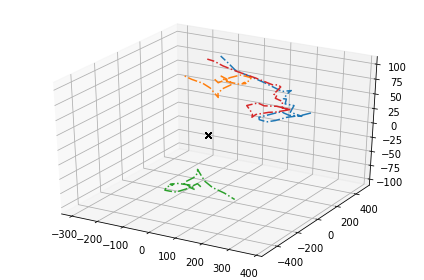

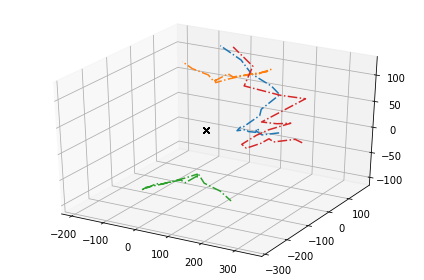

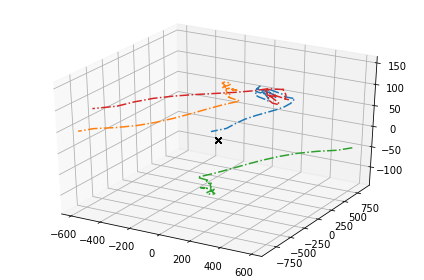

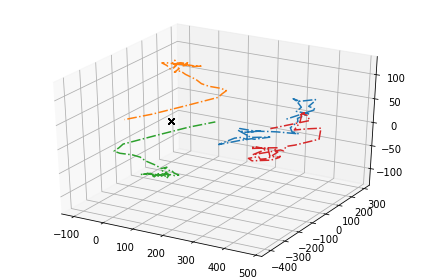

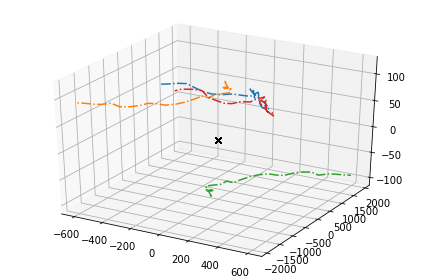

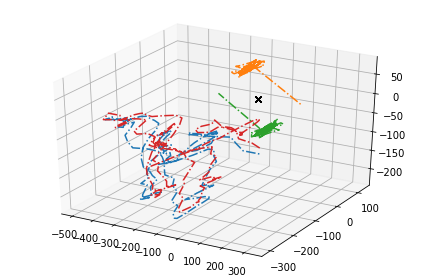

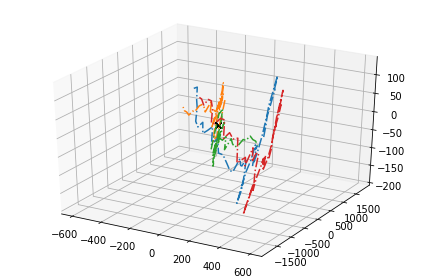

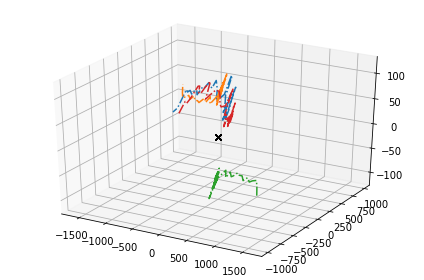

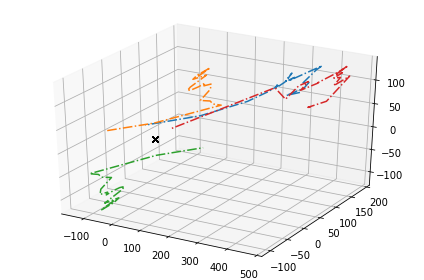

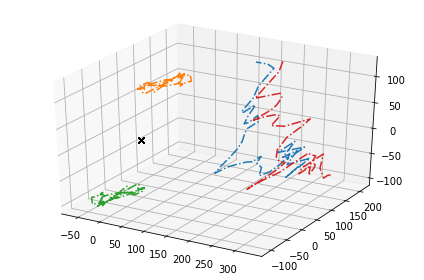

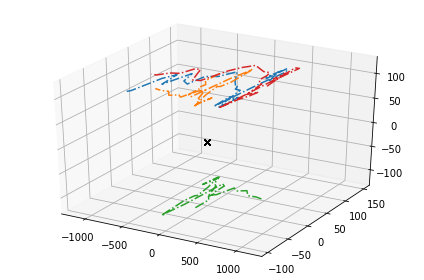

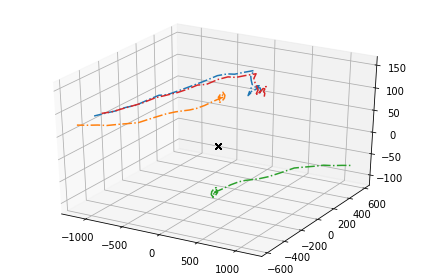

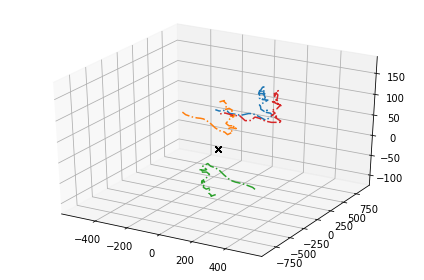

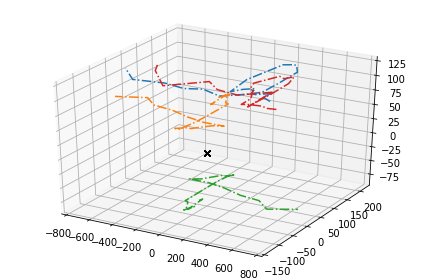

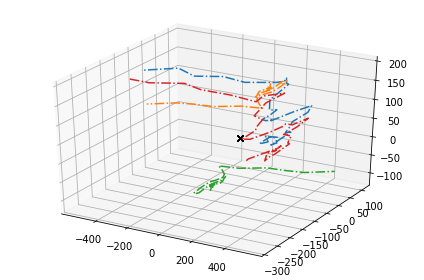

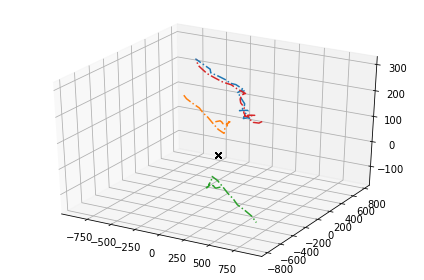

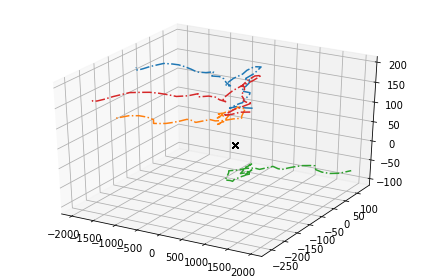

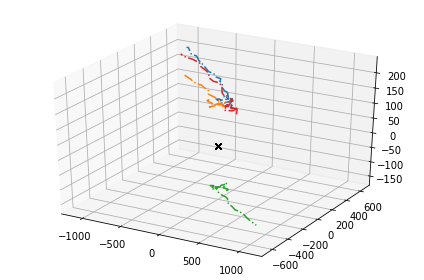

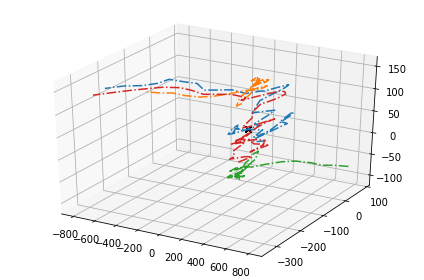

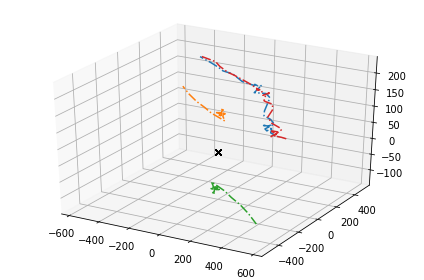

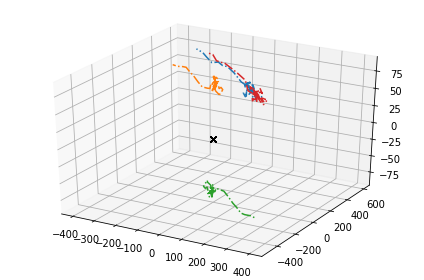

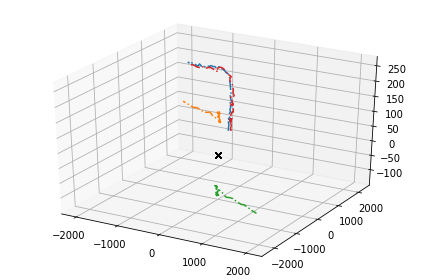

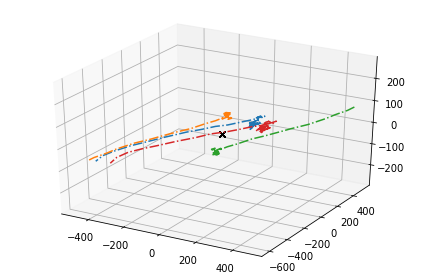

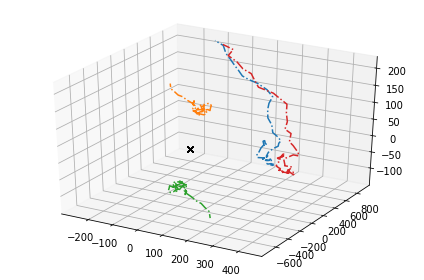

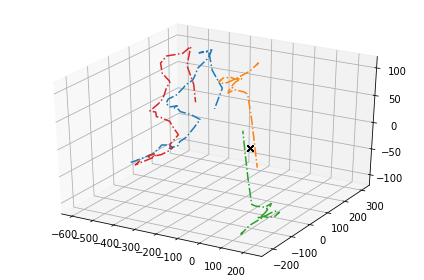

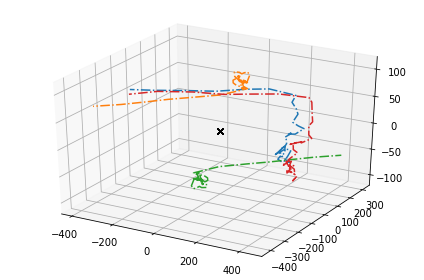

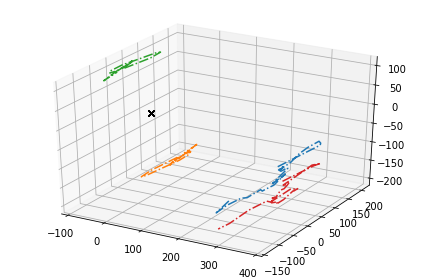

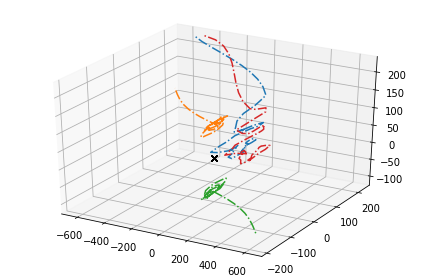

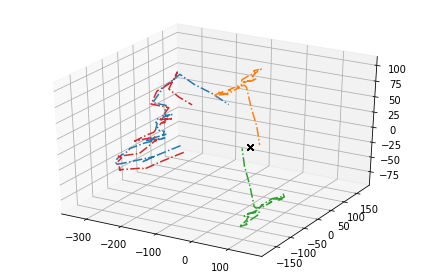

In [31]:
"""Plot resulting position tracks in 3D"""
from mpl_toolkits import mplot3d


for i in np.arange(ntrials):
    fig, ax = plt.subplots()
    ax = plt.axes(projection='3d')
    p00 = np.zeros((BoB[i]['trans'].shape))
    p01 = BoB[i]['trans'].copy()
    p02 = Sh[i]['trans'].copy()
    p03 = BoT[i]['trans'].copy()
    p04 = ToB[i]['trans'].copy()
    
    ntime, npts = p01.shape
    t = np.linspace(0, ntime, ntime, False)
    
    
    plt.plot(p00[:,0], p00[:,1], p00[:,2], 'x', color='black')
    plt.plot(p01[:,0], p01[:,1], p01[:,2], '-.')
    plt.plot(p02[:,0], p02[:,1], p02[:,2], '-.')
    plt.plot(p03[:,0], p03[:,1], p03[:,2], '-.')
    plt.plot(p04[:,0], p04[:,1], p04[:,2], '-.')

    plt.tight_layout()
    plt.show()
#     FigureName = "3D Trajectories of transformed body points for landing" + str(i)
#     plt.savefig(FigureName % i, dpi=300)

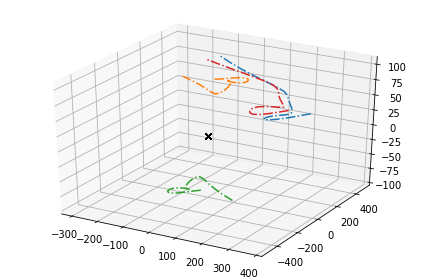

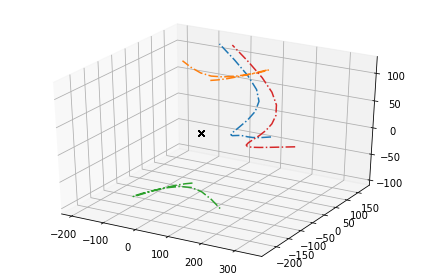

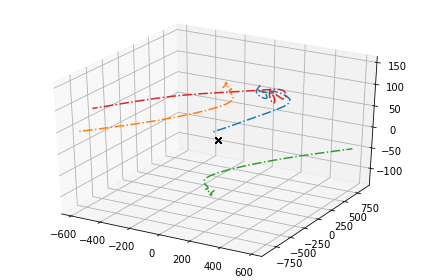

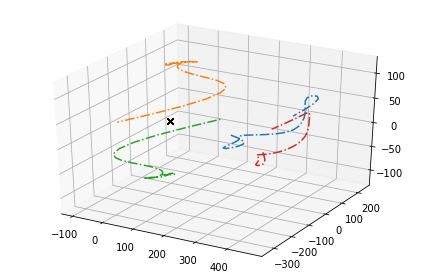

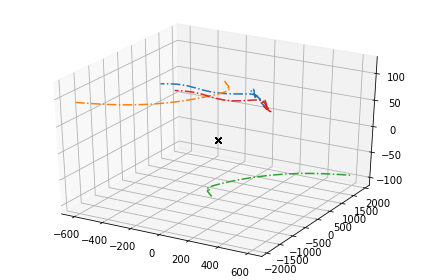

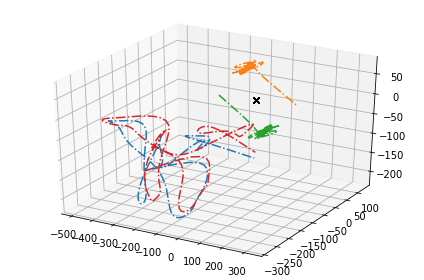

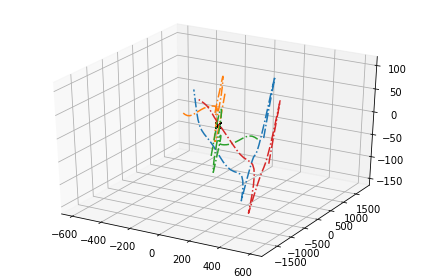

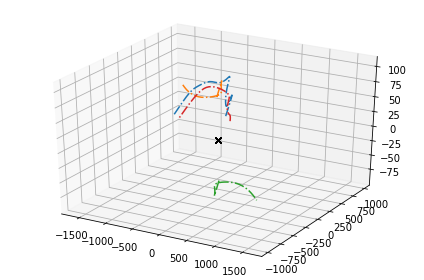

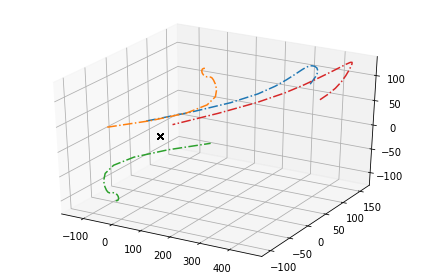

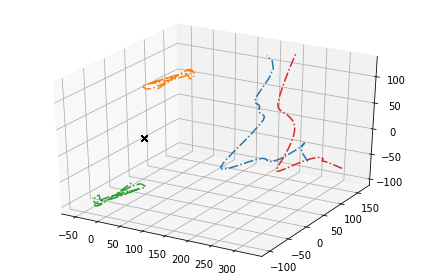

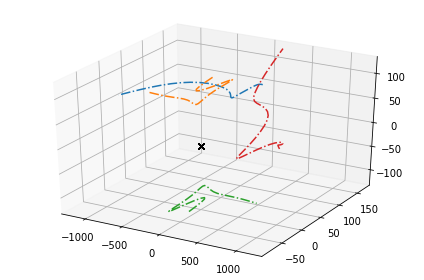

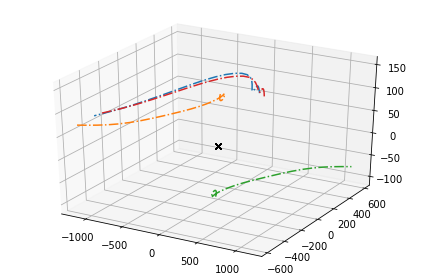

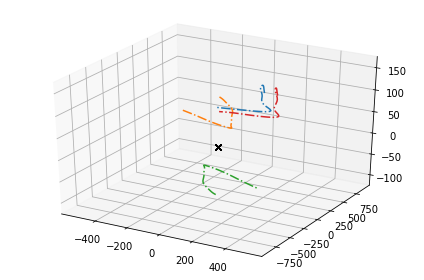

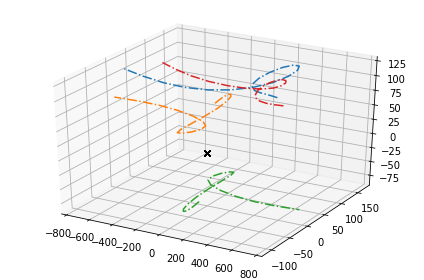

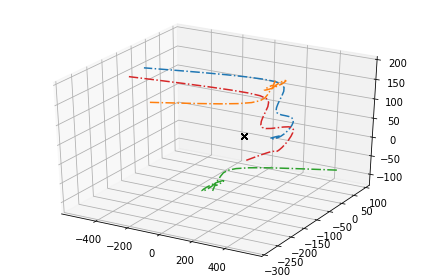

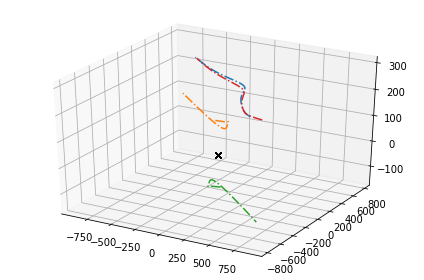

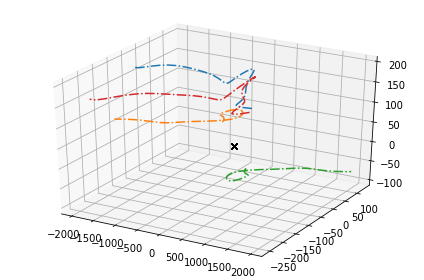

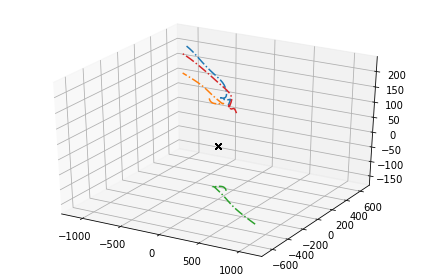

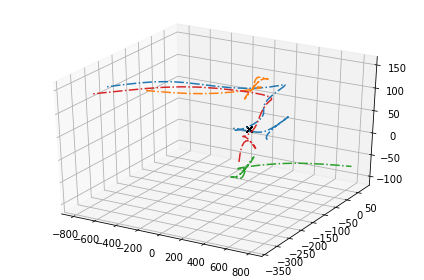

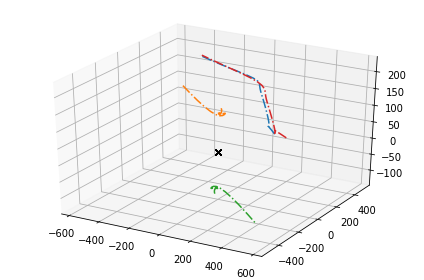

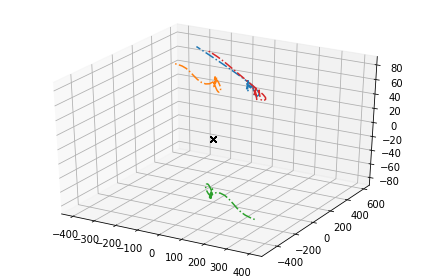

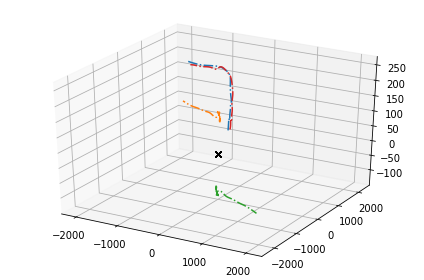

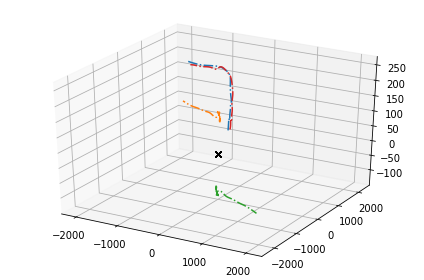

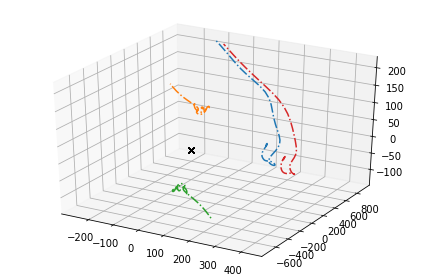

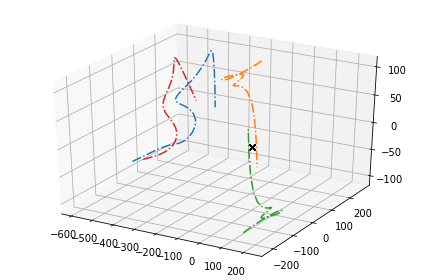

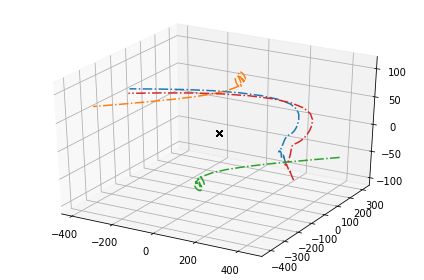

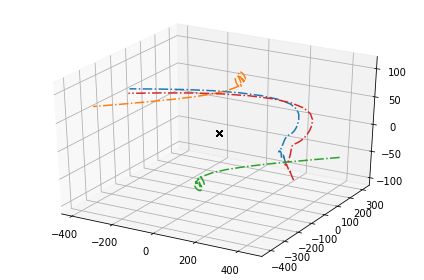

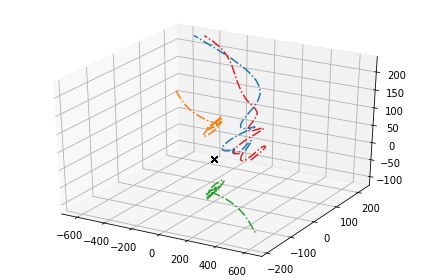

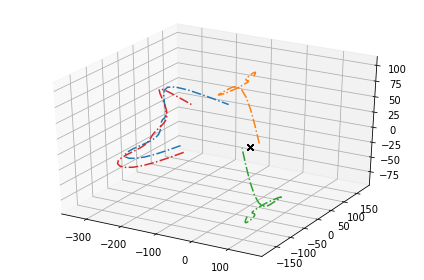

In [32]:
for i in np.arange(ntrials):
    fig, ax = plt.subplots()
    ax = plt.axes(projection='3d')
    p00 = np.zeros((BoB[i]['trans'].shape))
    p01 = BoB[i]['pf_I'].copy()
    p02 = Sh[i]['pf_I'].copy()
    p03 = BoT[i]['pf_I'].copy()
    p04 = ToB[i]['pf_I'].copy()
    
    ntime, npts = p01.shape
    t = np.linspace(0, ntime, ntime, False)
    
    
    plt.plot(p00[:,0], p00[:,1], p00[:,2], 'x', color='black')
    plt.plot(p01[:,0], p01[:,1], p01[:,2], '-.')
    plt.plot(p02[:,0], p02[:,1], p02[:,2], '-.')
    plt.plot(p03[:,0], p03[:,1], p03[:,2], '-.')
    plt.plot(p04[:,0], p04[:,1], p04[:,2], '-.')

    plt.tight_layout()
    plt.show()
#     FigureName = "3D Trajectories of transformed body points for landing" + str(i)
#     plt.savefig(FigureName % i, dpi=300)

In [43]:
gaze_3D = {}
head_3D = {}
body_3D = {}

i_imp_gaze = []
i_imp_head = []
i_imp_body = []

for i in np.arange(ntrials):
    base = BoB[i]['pf_I'].copy()
    tip = ToB[i]['pf_I'].copy()
    shou = Sh[i]['pf_I'].copy()
    tail = BoT[i]['pf_I'].copy()
    
    i_imp_idx = int(idx_data['feet_impact'].iloc[i] - idx_data['start_index'].iloc[i])
    
    if len(base) > len(tip):
        base = base[:len(tip), :]
        radians = find_3D_angle(base,tip)
        angle = np.round(np.degrees(radians))
        gaze_3D[i] = angle
        i_imp_gaze.append(angle[i_imp_idx])
    elif len(base) < len(tip):
        tip = tip[:len(base), :]
        radians = find_3D_angle(base,tip)
        angle = np.round(np.degrees(radians))
        gaze_3D[i] = angle
        i_imp_gaze.append(angle[i_imp_idx])
    else:
        radians = find_3D_angle(base,tip)
        angle = np.round(np.degrees(radians))
        gaze_3D[i] = angle
        i_imp_gaze.append(angle[i_imp_idx])
    
    if len(base) > len(shou):
        base = base[:len(tip), :]
        radians = find_3D_angle(shou,base)
        angle = np.round(np.degrees(radians))
        head_3D[i] = angle
        i_imp_head.append(angle[i_imp_idx])
    elif len(shou) > len(base):
        shou = shou[:len(base), :]
        radians = find_3D_angle(shou,base)
        angle = np.round(np.degrees(radians))
        head_3D[i] = angle
        i_imp_head.append(angle[i_imp_idx])
    else:
        radians = find_3D_angle(shou,base)
        angle = np.round(np.degrees(radians))
        head_3D[i] = angle
        i_imp_head.append(angle[i_imp_idx])
    
    if len(tail) > len(shou):
        tail = tail[:len(shou), :]
        radians = find_3D_angle(tail,shou)
        angle = np.round(np.degrees(radians))
        body_3D[i] = angle
        i_imp_body.append(angle[i_imp_idx])
    elif len(shou) > len(tail):
        shou = shou[:len(tail), :]
        radians = find_3D_angle(tail,shou)
        angle = np.round(np.degrees(radians))
        body_3D[i] = angle
        i_imp_body.append(angle[i_imp_idx])
    else:
        radians = find_3D_angle(tail,shou)
        angle = np.round(np.degrees(radians))
        body_3D[i] = angle
        i_imp_body.append(angle[i_imp_idx])
        
#     if len(tail) > len(shou):
#         tail = tail[:len(shou), :]
#         radians = find_body_angle(tail,shou)
#         angle = np.round(np.degrees(radians))
#         body_3D[i] = angle
#         i_imp_body.append(angle[i_imp_idx])
#     elif len(shou) > len(tail):
#         shou = shou[:len(tail), :]
#         radians = find_3D_angle(tail,shou)
#         angle = np.round(np.degrees(radians))
#         body_3D[i] = angle
#         i_imp_body.append(angle[i_imp_idx])
#     else:
#         radians = find_3D_angle(tail,shou)
#         angle = np.round(np.degrees(radians))
#         body_3D[i] = angle
#         i_imp_body.append(angle[i_imp_idx])
    
idx_data['body_angle_initial_impact'] = i_imp_body
idx_data['head_angle_initial_impact'] = i_imp_head
idx_data['gaze_angle_initial_impact'] = i_imp_gaze

In [68]:
import seaborn as sns

from matplotlib import rcParams as rc
from pandas.plotting import scatter_matrix
from mpl_toolkits import mplot3d

bmap = sns.diverging_palette(255, 133, l=60, n=7, center='dark')

rc = {'pdf.fonttype':42, 'ps.fonttype':42, 'mathtext.fontset':'cm'}
sns.set('paper', 'ticks', font='Calibri', palette='deep',
        font_scale=1.5, color_codes=True, rc=rc)

%matplotlib inline

C:\ProgramData\Miniconda3\envs\notebook\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


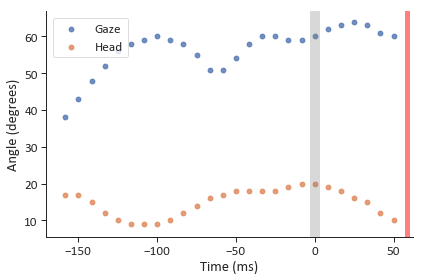

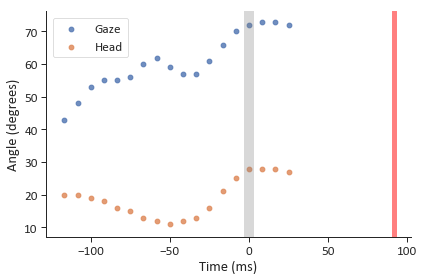

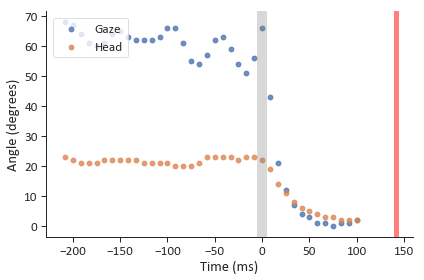

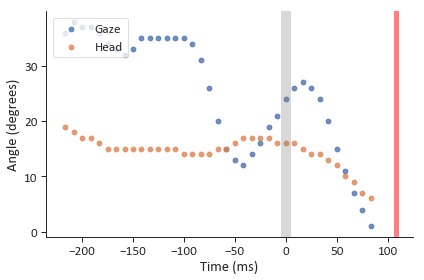

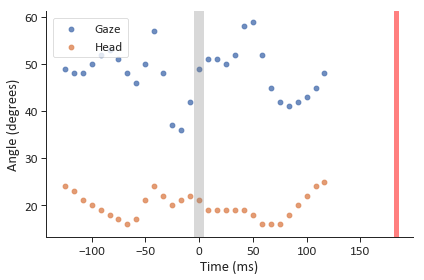

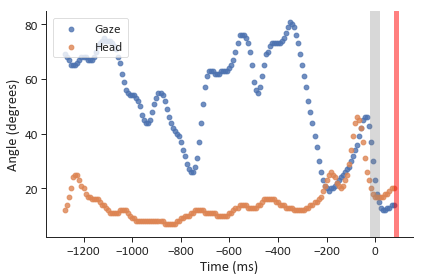

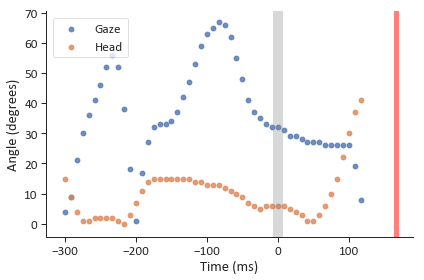

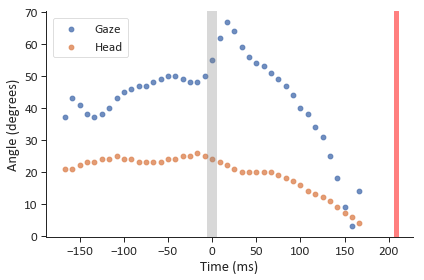

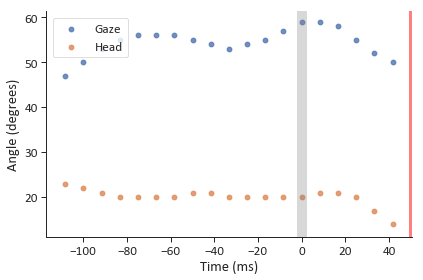

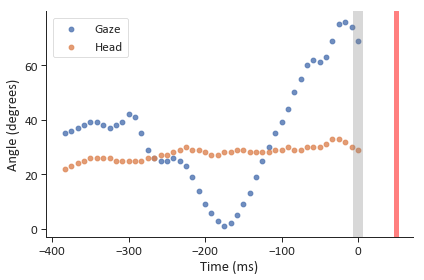

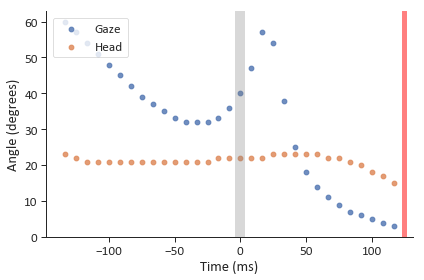

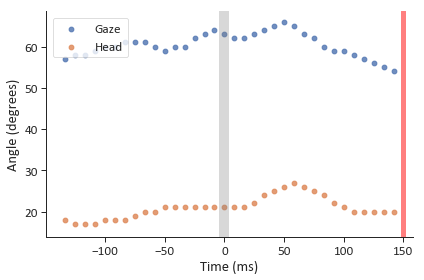

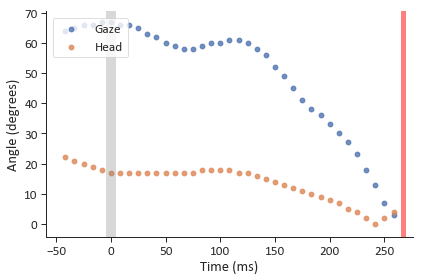

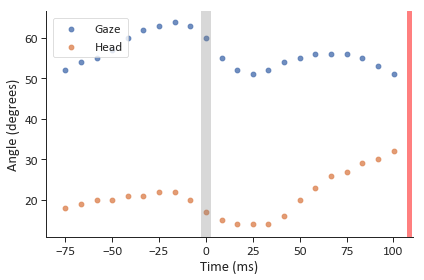

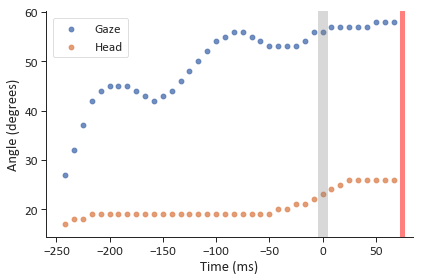

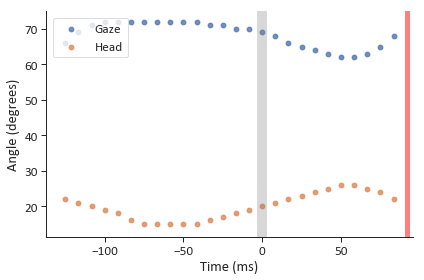

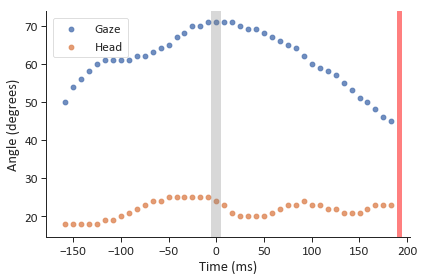

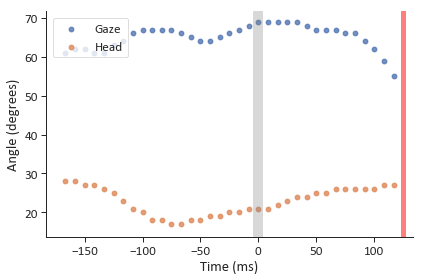

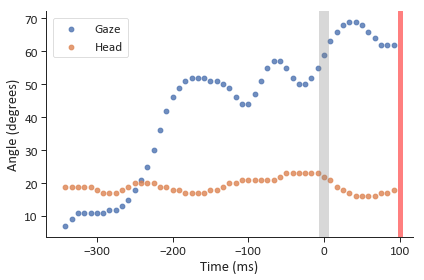

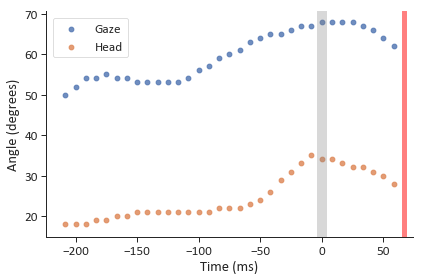

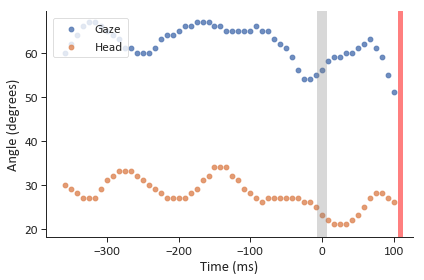

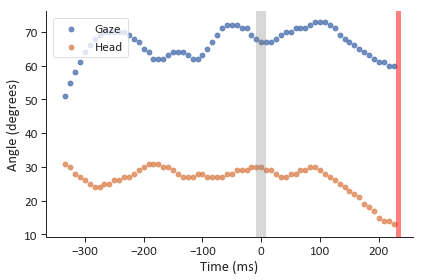

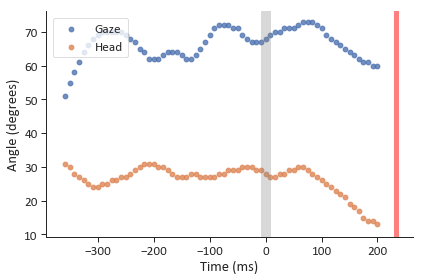

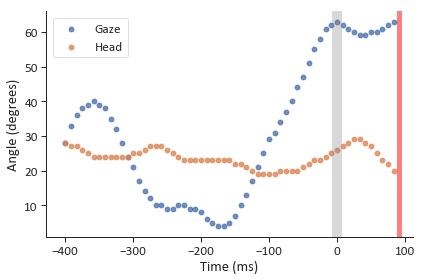

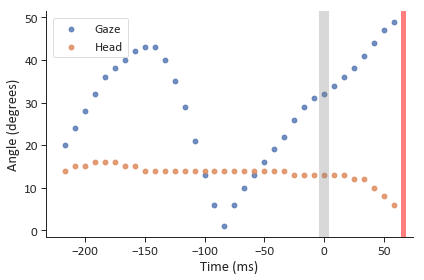

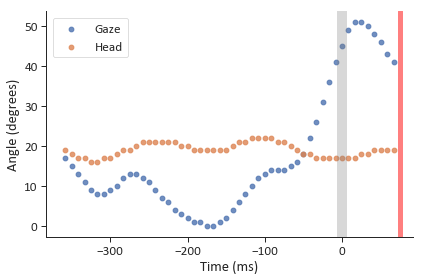

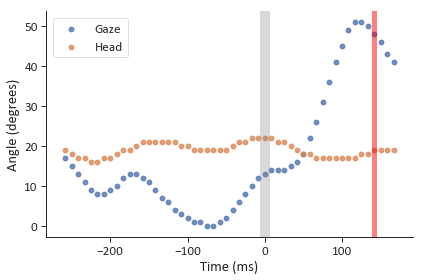

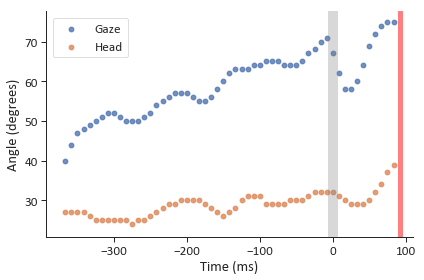

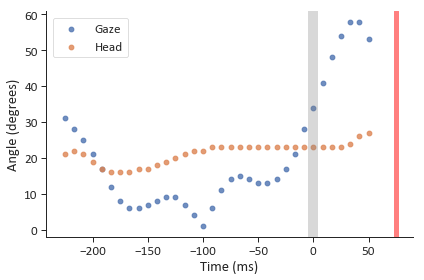

In [119]:
for i in np.arange(ntrials):
    fig, ax = plt.subplots()
    ntime = len(gaze_3D[i])
    t = np.linspace(0, ntime, ntime, False)
    t_imp = int(idx_data['feet_impact'].iloc[i] - idx_data['start_index'].iloc[i])
    b_imp = int(idx_data['breast_impact'].iloc[i] - idx_data['feet_impact'].iloc[i])
    t_trans = b_imp * dt * 1000
    
    t = t-t_imp
    ms = t * dt * 1000
    
    ax = sns.regplot(ms, body_3D[i], fit_reg=False)
    ax = sns.regplot(ms, gaze_3D[i], fit_reg=False)
    ax = sns.regplot(ms, head_3D[i], fit_reg=False)
    
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Angle (degrees)')
    
    plt.legend(labels=['Body', 'Gaze', 'Head'], loc=2)
    plt.axvline(x=0, color='gray', linewidth=10, alpha=0.3)
    plt.axvline(x=t_trans, color='red', linewidth=5, alpha=0.5)
    
    sns.despine()
    plt.tight_layout()
#     plt.show()
    FigureName = "Angles for landing " + str(i + 1)
    plt.savefig(FigureName % i, dpi=300)
    


In [96]:
"""Find range of motion for angles assuming all move to 0"""
b_rom = []
h_rom = []
g_rom = []

b_vel = []
h_vel = []
g_vel = []

transitions = []
for i in np.arange(ntrials):
    t_imp = int(idx_data['feet_impact'].iloc[i] - idx_data['start_index'].iloc[i])
    b_imp = int(idx_data['breast_impact'].iloc[i] - idx_data['start_index'].iloc[i])
    trans_dt = (b_imp - t_imp) * dt * 1000
    transitions.append(np.round(trans_dt,1))
    
    body = body_3D[i][t_imp:b_imp]
    if len(body) > 1:
        body_ROM = range_of_motion(body)        
        body_angle_vel, body_angle_acc = findiff(body, dt)
        
    else:
        body_angle_vel = np.nan
        body_angle_acc = np.nan
        body_ROM = np.nan
        
    b_rom.append(body_ROM)
    
    head = head_3D[i][t_imp:b_imp]
    if len(head) > 1:
        head_ROM = range_of_motion(head)    
        head_angle_vel, head_angle_acc = findiff(head, dt)
        
    else:
        head_angle_vel = np.nan
        head_angle_acc = np.nan
        head_ROM = np.nan
        
    h_rom.append(head_ROM)
    
    gaze = gaze_3D[i][t_imp:b_imp]
    if len(body) > 1:
        gaze_ROM = range_of_motion(gaze)      
        gaze_angle_vel, gaze_angle_acc = findiff(gaze, dt)
        
    else:
        gaze_angle_vel = np.nan
        gaze_angle_acc = np.nan
        gaze_ROM = np.nan
        
    g_rom.append(gaze_ROM)
    
    body_mean_ang_vel = np.mean(body_angle_vel)
    head_mean_ang_vel = np.mean(head_angle_vel)
    gaze_mean_ang_vel = np.mean(gaze_angle_vel)
    
    b_vel.append(body_mean_ang_vel)
    h_vel.append(head_mean_ang_vel)
    g_vel.append(gaze_mean_ang_vel)

idx_data['transition_time'] = transitions

idx_data['body_range_of_motion'] = b_rom
idx_data['head_range_of_motion'] = h_rom
idx_data['gaze_range_of_motion'] = g_rom

idx_data['body_angle_mean_vel'] = np.round(b_vel)
idx_data['head_angle_mean_vel'] = np.round(h_vel)
idx_data['gaze_angle_mean_vel'] = np.round(g_vel)
    

In [97]:
idx_data

,date,video,feet_extended,feet_impact,breast_impact,tail_flip,base_of_bill_start,base_of_bill_end,tip_of_bill_start,tip_of_bill_end,...,head_angle_initial_impact,gaze_angle_initial_impact,transition_time,body_range_of_motion,head_range_of_motion,gaze_range_of_motion,body_angle_mean_vel,head_angle_mean_vel,gaze_angle_mean_vel,rsv_id
1,20181025,B01a,33.0,53.0,60.0,NaN,34.0,156.0,34.0,156.0,...,20.0,60.0,58.3,20.0,10.0,0.0,-308.0,-189.0,26.0,20181025_B01a
2,20181025,B01b,NaN,46.0,57.0,NaN,32.0,98.0,32.0,98.0,...,28.0,72.0,91.7,56.0,1.0,0.0,-1860.0,-60.0,-0.0,20181025_B01b
3,20181025,B01c,NaN,47.0,64.0,NaN,22.0,162.0,22.0,162.0,...,22.0,66.0,141.7,29.0,20.0,66.0,-309.0,-189.0,-692.0,20181025_B01c
4,20181025,B02,36.0,53.0,66.0,NaN,27.0,64.0,27.0,64.0,...,16.0,24.0,108.4,54.0,10.0,23.0,-322.0,-104.0,-251.0,20181025_B02
5,20181025,B04,NaN,66.0,88.0,142.0,51.0,81.0,51.0,81.0,...,21.0,49.0,183.4,23.0,5.0,8.0,-204.0,16.0,24.0,20181025_B04
6,20181025,C01a,162.0,184.0,194.0,NaN,11.0,214.0,31.0,214.0,...,17.0,23.0,83.4,22.0,0.0,11.0,-282.0,30.0,-156.0,20181025_C01a
7,20181101,A01,33.0,38.0,58.0,104.0,2.0,104.0,2.0,104.0,...,6.0,32.0,166.7,61.0,5.0,24.0,-884.0,288.0,-252.0,20181101_A01
8,20181101,A02a,21.0,30.0,55.0,NaN,10.0,55.0,10.0,53.0,...,24.0,55.0,208.4,25.0,20.0,52.0,-166.0,-126.0,-129.0,20181101_A02a
9,20181108,A02a,NaN,28.0,34.0,NaN,15.0,37.0,15.0,37.0,...,20.0,59.0,50.0,5.0,6.0,9.0,-540.0,-130.0,-180.0,20181108_A02a
10,20181108,A02c,NaN,63.0,69.0,NaN,17.0,64.0,17.0,64.0,...,29.0,69.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,20181108_A02c


In [79]:
idx_data['rsv_id'] = idx_data['date'] + '_' + idx_data['video']

comp_data = pd.read_csv('CompositeData_Export.csv')
comp_data['rsv_vid_id'] = comp_data['date'].where(comp_data['rsv_vid_id'].isna() == False).astype(str).str.strip('.0') + '_' + comp_data['rsv_vid_id'].where(comp_data['rsv_vid_id'].isna() == False)

all_data = pd.merge(comp_data, idx_data, how='left', left_on=['rsv_vid_id'], right_on=['rsv_id'])

In [80]:
rsv_working_data = all_data[all_data['rsv_id'].isna() == False]

In [118]:
rsv_working_data

,Unnamed: 0,date_x,gopro_vid_id,usable_landings,sex,start_frame,impact_frame,end_frame,rsv_match,rsv_vid_id,...,head_angle_initial_impact,gaze_angle_initial_impact,transition_time,body_range_of_motion,head_range_of_motion,gaze_range_of_motion,body_angle_mean_vel,head_angle_mean_vel,gaze_angle_mean_vel,rsv_id
29,30,20181025,A03a,1,Male,2,15,37,1,20181025_B02,...,16.0,24.0,108.4,54.0,10.0,26.0,-322.0,-104.0,-251.0,20181025_B02
40,41,20181101,A01b,1,Male,3,44,62,1,20181101_A01,...,6.0,32.0,166.7,61.0,40.0,24.0,-884.0,288.0,-252.0,20181101_A01
53,54,20181101,A07d,1,Male,1099,1113,1159,1,20181101_A02a,...,24.0,55.0,208.4,51.0,20.0,64.0,-166.0,-126.0,-129.0,20181101_A02a
87,88,20181108,A01n,1,Male,519,532,545,1,20181108_A02a,...,20.0,59.0,50.0,15.0,7.0,9.0,-540.0,-130.0,-180.0,20181108_A02a
90,91,20181108,A01q,1,Female,507,571,586,1,20181108_A02c,...,29.0,69.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,20181108_A02c
94,95,20181108,A01u,1,Male,794,808,839,1,20181108_A02e,...,22.0,40.0,125.0,76.0,8.0,54.0,-252.0,-68.0,-284.0,20181108_A02e
97,98,20181108,A01x,1,Male,2253,2271,2296,1,20181108_A02h,...,21.0,63.0,150.0,77.0,7.0,12.0,-280.0,-7.0,-70.0,20181108_A02h
99,100,20181108,A02b,1,Male,114,127,158,1,20181108_A03a,...,17.0,67.0,266.7,38.0,18.0,64.0,-156.0,-45.0,-247.0,20181108_A03a
104,105,20181108,A02h,1,Male,395,423,461,1,20181108_A03c,...,17.0,60.0,108.4,35.0,18.0,9.0,-185.0,138.0,-125.0,20181108_A03c
105,106,20181108,A02i,1,Male,393,432,448,1,20181108_A03d,...,23.0,56.0,75.0,56.0,3.0,2.0,-333.0,47.0,40.0,20181108_A03d


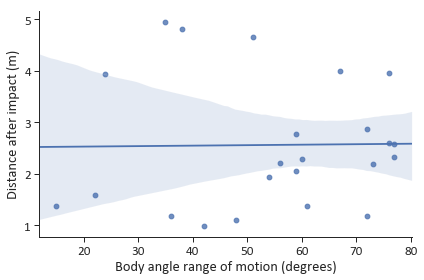

r-square = nan
p-value = nan


In [95]:
fig, ax = plt.subplots()
sns.regplot(rsv_working_data['body_range_of_motion'], rsv_working_data['distance_after_impact'])

x = rsv_working_data['body_range_of_motion']
y = rsv_working_data['distance_after_impact']

slope, intercept, r_value, p_value, std_error = scipy.stats.linregress(x, y)
r2 = r_value**2

numbers = 'r-square = ' + str(round(r2, 5)) + '\n' + 'p-value = ' + str(round(p_value, 5))

sns.despine()
ax.set_xlabel('Body angle range of motion (degrees)')
ax.set_ylabel('Distance after impact (m)')
plt.tight_layout()
plt.show()
# plt.savefig('body_ROM_VS_dist_after_impact',dpi=300)
print(numbers)

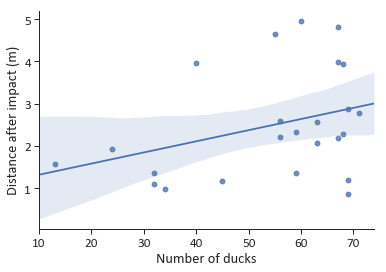

r-square = 0.11824
p-value = 0.09992


In [122]:
fig, ax = plt.subplots()
sns.regplot(rsv_working_data['gaze_angle_initial_impact'], rsv_working_data['distance_after_impact'], fit_reg = True)

x = rsv_working_data['gaze_angle_initial_impact']
y = rsv_working_data['distance_after_impact']

slope, intercept, r_value, p_value, std_error = scipy.stats.linregress(x, y)
r2 = r_value**2

numbers = 'r-square = ' + str(round(r2, 5)) + '\n' + 'p-value = ' + str(round(p_value, 5))

sns.despine()
ax.set_xlabel('Number of ducks')
ax.set_ylabel('Distance after impact (m)')
plt.show()
# plt.savefig('N_LandingArea_VS_dist_after_impact',dpi=300)
print(numbers)

r_squared = 0.3278125965009358
p-value = 0.0034570291656979713


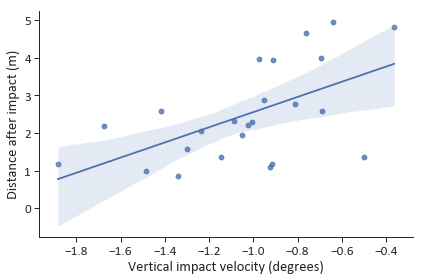

In [115]:
"""Generalized scatter plot analysis"""
fig, ax = plt.subplots()
x = rsv_working_data['vert_impact_speed']
y = rsv_working_data['distance_after_impact']
# pt_labels = to_plot['rsv_vid_id']

sns.regplot(data=rsv_working_data, x='vert_impact_speed', y='distance_after_impact', fit_reg=True, truncate=True, color='b')
# sns.regplot(data=high_taudot, x='mean_angle', y='distance_after_impact', fit_reg=False, color='r')
# sns.regplot(data=idx_data, x='tau_dot', y='impact_angle')

# df = pd.DataFrame(x, y, pt_labels)
# sns.regplot(data=df, x=x, y=y, fit_reg=False)

# def label_point(x, y, val, ax):
#     a = pd.concat({'x':x, 'y':y, 'val':val}, axis=1)
#     for i, point in a.iterrows():
#         ax.text(point['x']+.1, point['y'], str(point['val']))

# label_point(x, y, pt_labels, plt.gca())

# plt.scatter(x,y)

slope, intercept, r_value, p_value, std_error = scipy.stats.linregress(x, y)
r2 = r_value**2
# plt.plot(x, intercept + slope*x, 'g', label='fitted line')

numbers = 'r-square = ' + str(round(r2, 5)) + '\n' + 'p-value = ' + str(round(p_value, 5))
# ax.text(25, 5, numbers, fontsize=12)

ax.set_xlabel('Vertical impact velocity (degrees)')
ax.set_ylabel('Distance after impact (m)')
# ax.set_title('Impact speed vs taudot')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("Distance after impact vs vertical impact velocity", dpi=300)

print('r_squared =', r2)
print('p-value =', p_value)

In [99]:
rsv_working_data['body_range_of_motion'].describe()

count    23.000000
mean     54.347826
std      18.967936
min      15.000000
25%      40.000000
50%      59.000000
75%      72.000000
max      77.000000
Name: body_range_of_motion, dtype: float64

In [114]:
"""General linear regression model"""
var = ['horz_impact_speed', 'impact_angle', 'mean_angle', 'transition_time', 'vert_impact_speed']

ind_var = rsv_working_data.loc[:,var]
dep_var = rsv_working_data['distance_after_impact']

# print('Binomial')
# glm_binom = sm.GLM(dep_var, ind_var, family=sm.families.Binomial())
# res = glm_binom.fit()
# print(res.summary())
# print('\n')

print('Gamma')
glm_gamma = sm.GLM(dep_var, ind_var, family=sm.families.Gamma(sm.families.links.log))
res = glm_gamma.fit()
print(res.summary())
print('\n')

# print('Gaussian')
# glm_gaus = sm.GLM(dep_var, ind_var, family=sm.families.Gaussian())
# res = glm_gaus.fit()
# print(res.summary())


Gamma
                   Generalized Linear Model Regression Results                   
Dep. Variable:     distance_after_impact   No. Observations:                   24
Model:                               GLM   Df Residuals:                       19
Model Family:                      Gamma   Df Model:                            4
Link Function:                       log   Scale:                        0.039737
Method:                             IRLS   Log-Likelihood:                -12.095
Date:                   Thu, 02 Jan 2020   Deviance:                      0.78641
Time:                           18:28:31   Pearson chi2:                    0.755
No. Iterations:                       11   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
horz_impact_speed     0.2039      0.036      5.593      0.000       0.132       0.27

In [ ]:
scatter_matrix(rsv_working_data[['body_angle_mean_vel','head_angle_mean_vel', 'gaze_angle_mean_vel', 'transition_time', 'distance_after_impact']], figsize=(12,12))

# 'gaze_range_of_motion', 'body_range_of_motion','head_range_of_motion', 'body_angle_initial_impact', 'head_angle_initial_impact','gaze_angle_initial_impact',  